# Машинное обучение

## Факультет математики НИУ ВШЭ

### 2018-2019 учебный год

Лектор: Илья Щуров

Семинаристы: Евгения Ческидова, Евгений Ковалев

Ассистенты: Константин Ваниев, Софья Дымченко

# Семинар 10

Сегодня мы:

- познакомимся с алгоритмами ансамблирования решающих деревьев

    - bagging

    - gradient boosting


## Некоторые факты о линейных моделях и решающих деревьях

- **Linear Model**
    - Слишком простые
    - Не сильно меняются при небольшом изменении выборки
- **Tree Model**
    - Слишком сложные -- легко закодировать всю выборку деревом
    - Сильно меняются при небольшом изменении выборки

### Загрузим датасет Титаник

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [2]:
titanic = pd.read_csv('titanic.csv')[['Survived', 'Pclass', 'Sex', 'Age', 'Fare']]
titanic.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


In [3]:
sex_encoder = LabelEncoder()
titanic.Sex = sex_encoder.fit_transform(titanic.Sex)
features = ['Pclass', 'Sex', 'Age', 'Fare']
X, y = titanic[features].values, titanic.Survived.values
X = np.nan_to_num(X)

### Обучим линейную модель на разных подвыборках, похожи ли коэфиценты?

In [4]:
from sklearn.linear_model import LogisticRegression

for n_items in [200, 500]:
    reg = LogisticRegression(solver='lbfgs').fit(X[:n_items], y[:n_items])
    print('n_items', n_items, 'w = ',', '.join(map(lambda x: '%.4f' % x, reg.coef_[0])))

n_items 200 w =  -0.9097, -2.5839, -0.0323, -0.0069
n_items 500 w =  -0.8532, -2.5949, -0.0168, -0.0010


### Обучем деревья на тех же подвыборках, похожи ли деревья?

In [5]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree1 = DecisionTreeClassifier().fit(X[:200], y[:200])
tree2 = DecisionTreeClassifier().fit(X[:500], y[:500])

Если не работает pydot, то можно установить pydotplus и заменить все включения. Дополнительно необходимо установить graphviz для отображения дерева.
Подробности установки можно найти на http://graphviz.org/download/

* Для пользователей linux (ubuntu):
    `sudo apt install graphviz`

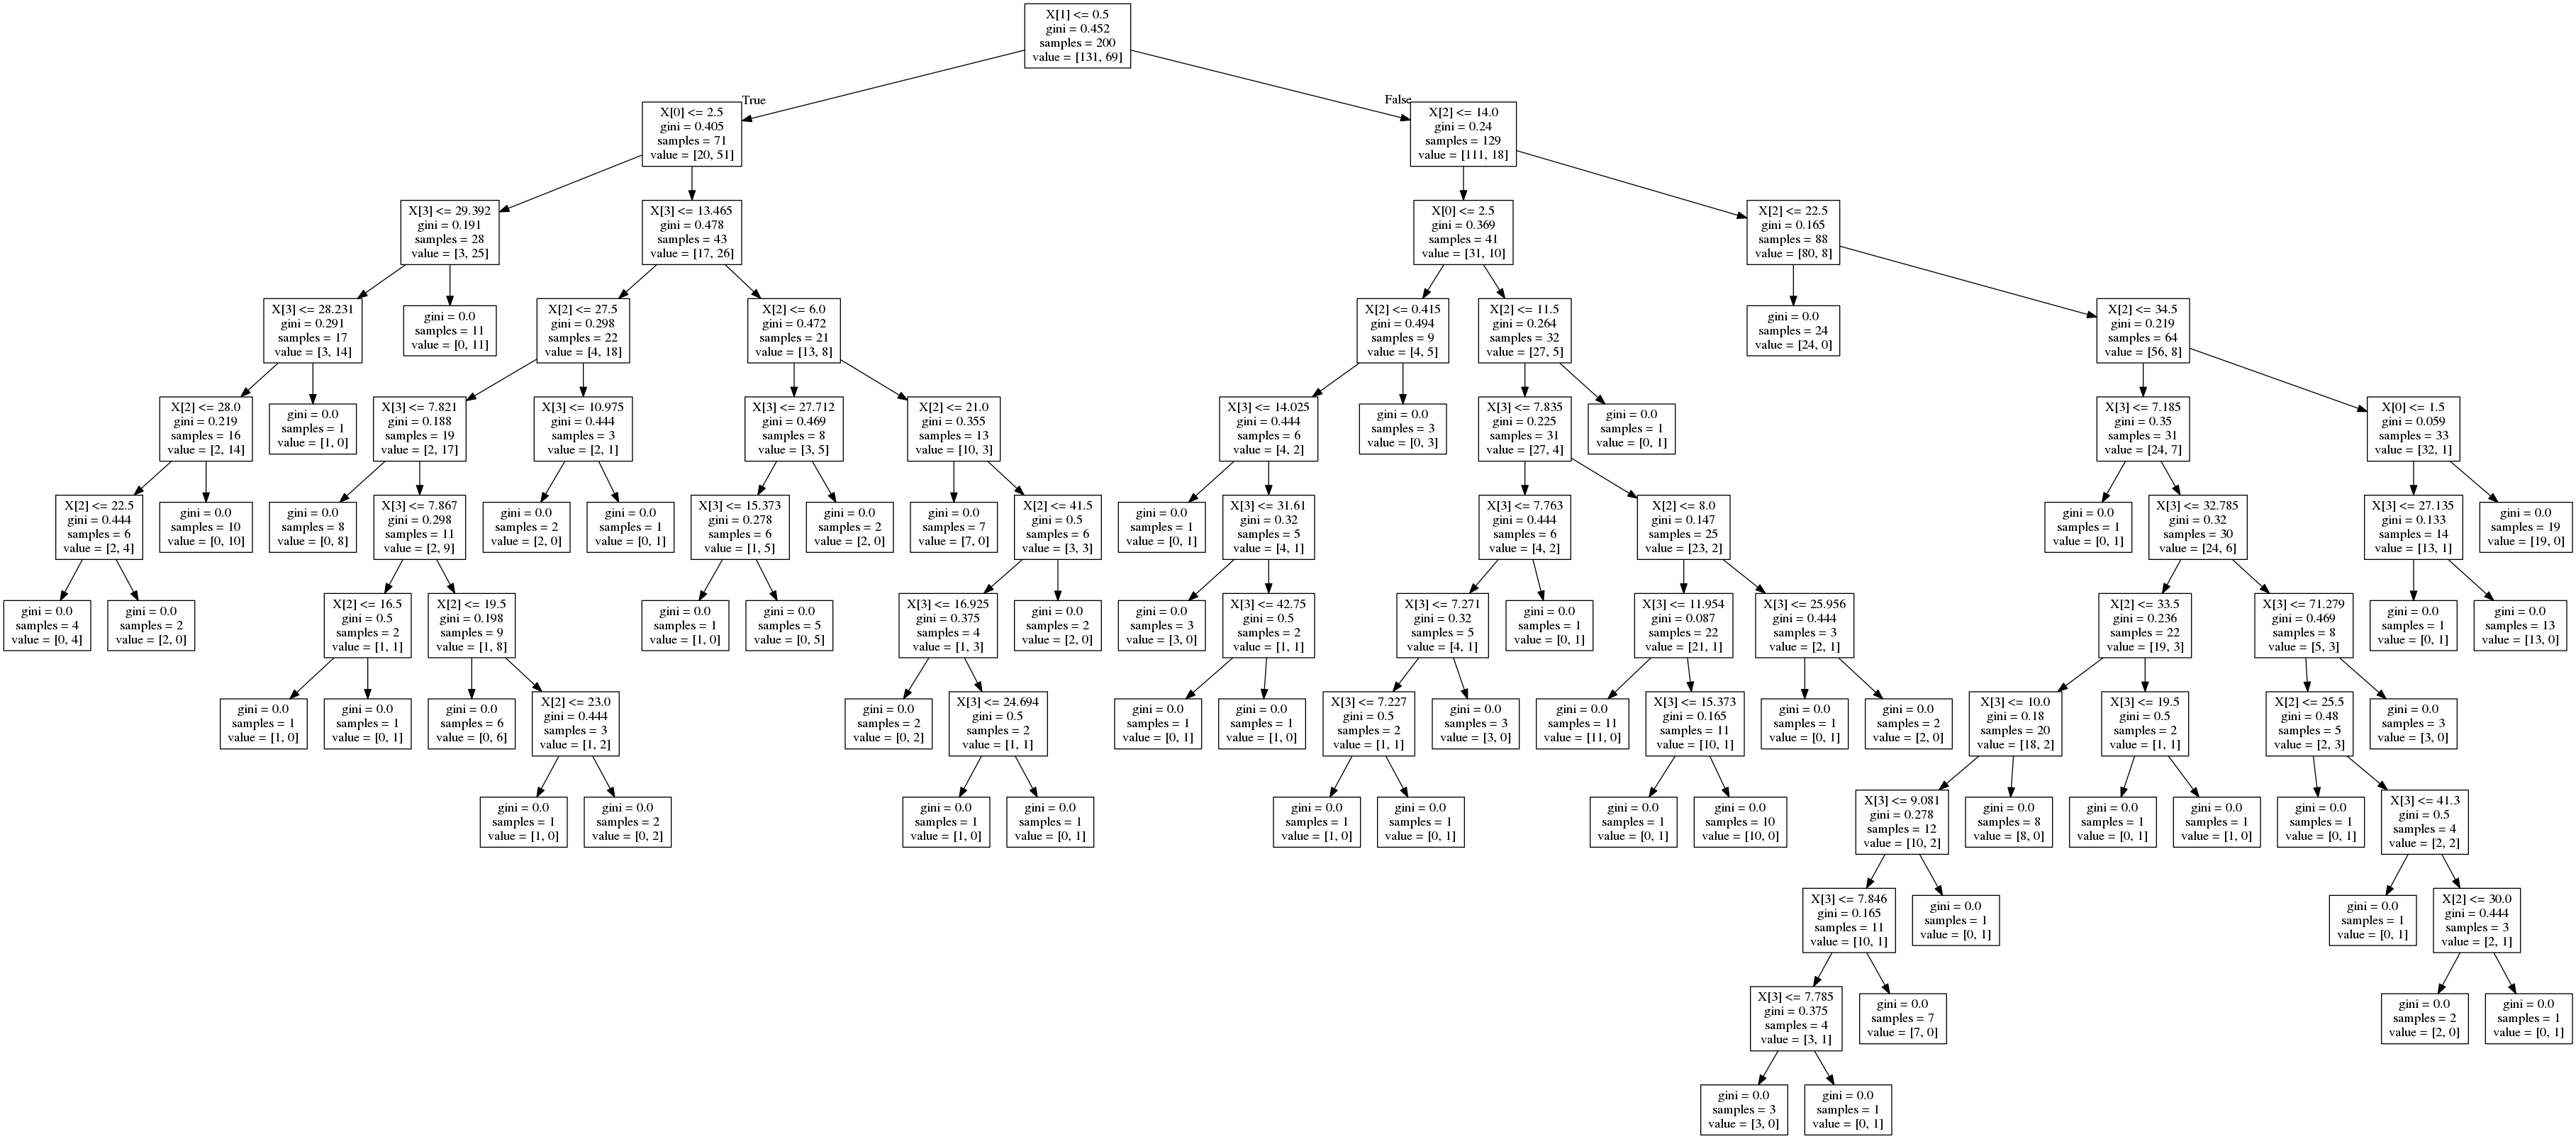

In [6]:
import pydot 
from io import StringIO
from IPython.display import Image  

dot_data = StringIO()  
export_graphviz(tree1, out_file=dot_data)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
Image(graph.create_png())

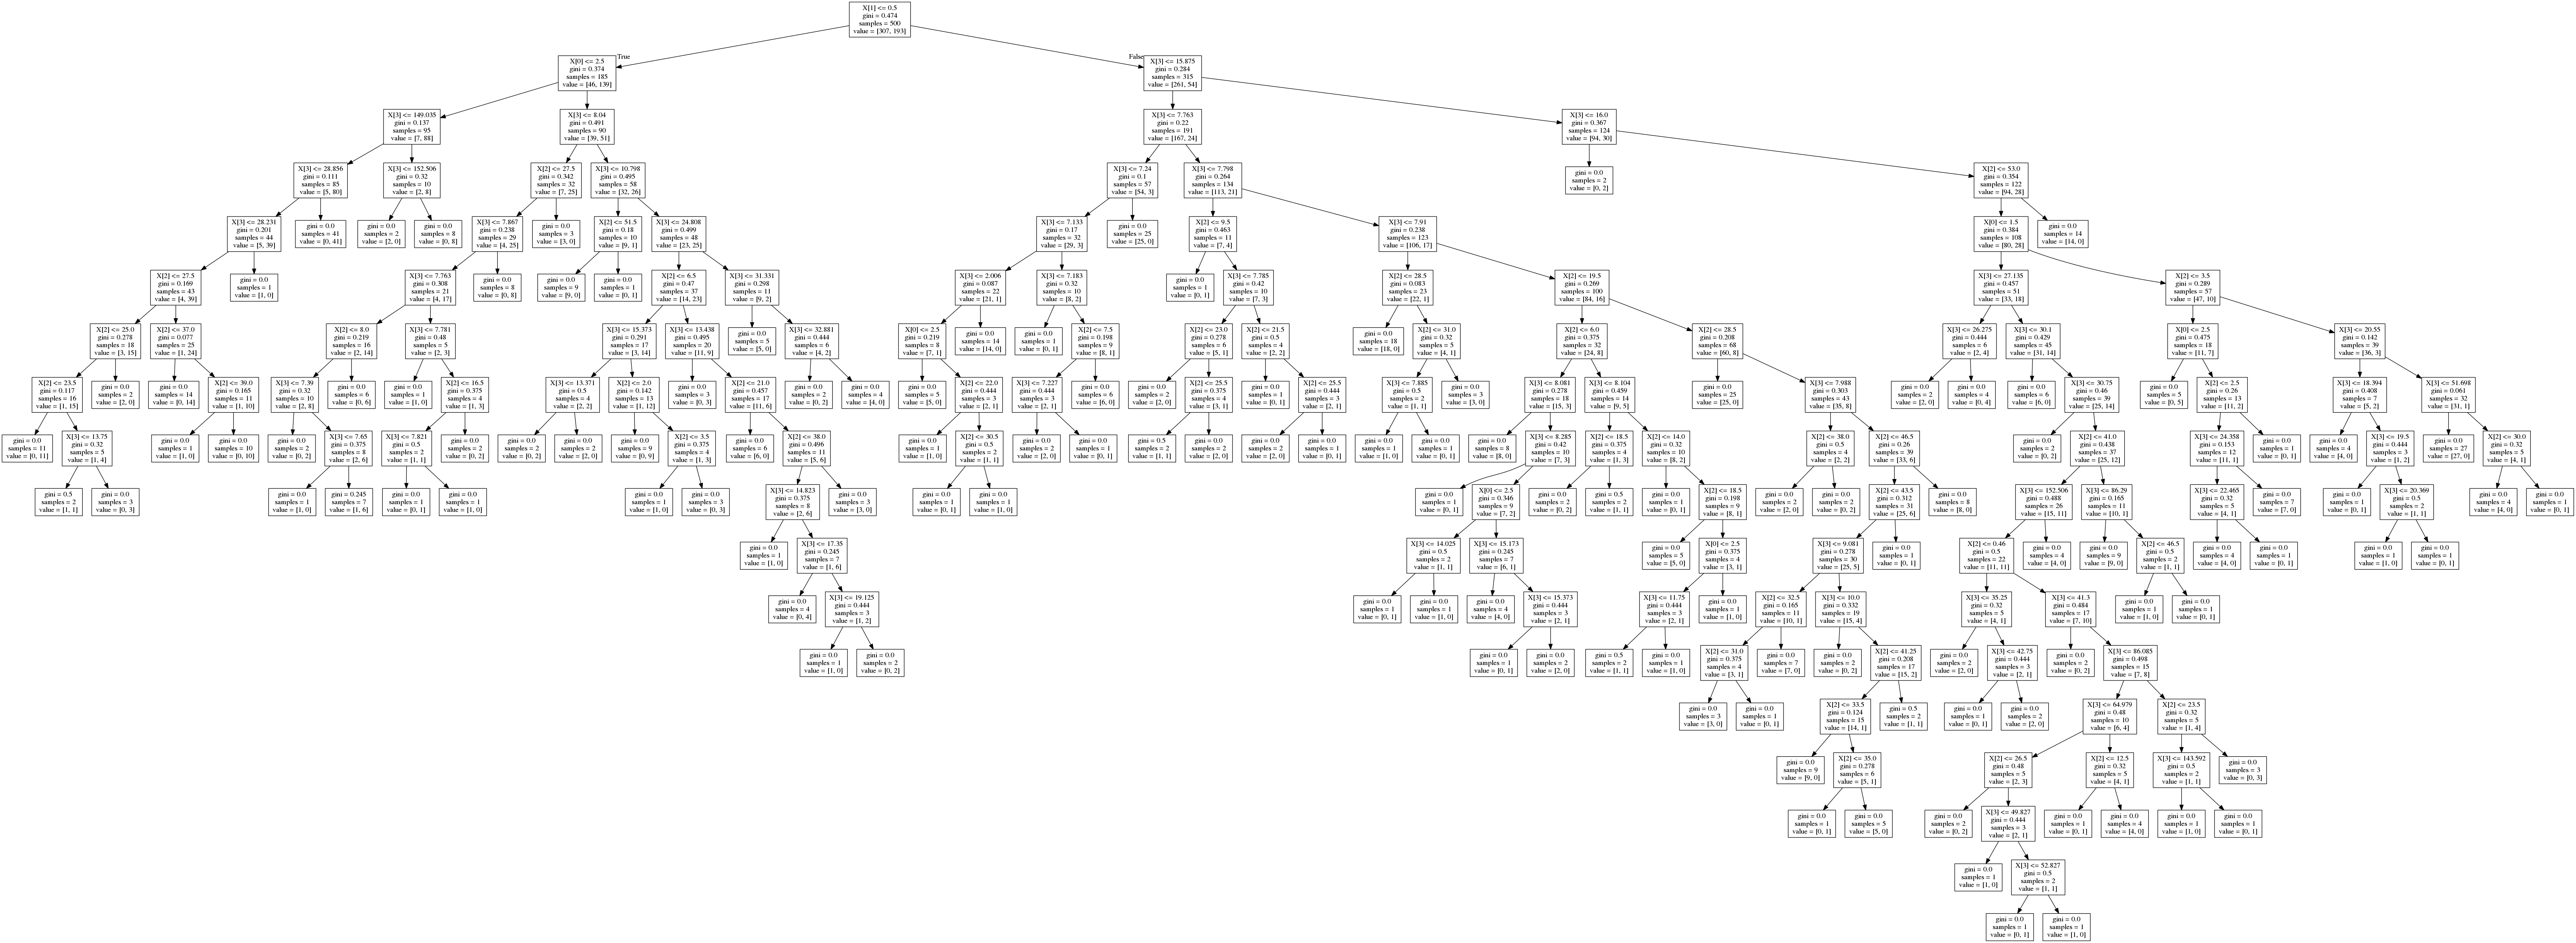

In [7]:
dot_data = StringIO()  
export_graphviz(tree2, out_file=dot_data)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
Image(graph.create_png()) 

В терминах **смещения** и **разброса**, у какой из двух моделей больший разброс, а у какой большее смещение?

# Ансамблирование

Уместна история о слепых мудрецах, каждый из которых описывает слона по-своему.

<img src="https://cdn-images-1.medium.com/max/1560/1*10t9S7xvWE5Z3NEZrmHG2w.jpeg" width=700>

# Bagging

- метод ансамблирования базовых алгоритмов, при котором каждый отдельный алгоритм обучается на случайной подвыборке с возвращением, затем предсказания алгоритмов усредняются.

- сэмплирование из выборки с возвращением называется **бутстрепом**, поэтому альтернативное название метода беггинга -- *bootstrap aggregation*.

### Theoretical Background

- Работает, потому что не ухудшает смещение, а разброс уменьшается линейно (если алгоритмы не коррелированы)
- Нужны модели с маленьким смещением (Какие???)
- Нужны некоррелированные модели

Help: Раздел 3.2 https://github.com/esokolov/ml-course-msu/blob/master/ML15-spring/lecture-notes/Sem04_ensembles.pdf  

In [8]:
adult = pd.read_csv(
    './adult.data', 
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"], 
    header=None, na_values="?")

In [9]:
adult.head(2)

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [10]:
adult = pd.get_dummies(adult)
adult.head(2)

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass_ ?,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Target_ <=50K,Target_ >50K
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [11]:
adult["Target"] = adult["Target_ >50K"]
X, y = adult[adult.columns[:-3]].values, adult[adult.columns[-1]].values

In [12]:
# нулей примерно в 3 раза больше, чем единиц
len(y[y==0])/len(y[y==1])

3.152659099604642

### Беггинг на лог-регрессиях

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier

In [14]:
# какой roc_auc дает одна логрегрессия?
lr = LogisticRegression()
scores1 = cross_val_score(lr, X, y, cv=4, n_jobs=4, scoring='roc_auc')
print(scores1.mean())

0.5823386751313112


In [210]:
# а что получится при ансамблировании?
<your code here>

### Беггинг на деревьях

In [16]:
from sklearn.tree import DecisionTreeClassifier

In [17]:
# какой roc_auc дает одно решающее дерево?
dt = DecisionTreeClassifier()
scores1 = cross_val_score(dt, X, y, cv=4, n_jobs=4, scoring='roc_auc')
print(scores1.mean())

0.7497200064717172


In [18]:
# а что получится при ансамблировании?
clf2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100)
scores2 = cross_val_score(clf2, X, y, cv=4, n_jobs=4, scoring='roc_auc')
print(scores2.mean())

0.9029853725545065


\*Можно повизуализировать корреляции предсказаний линейных регрессий и деревьев и увидеть разницу*

# Gradient Boosting

### Градиентный спуск

Самый простой метод минимизации функции, для оптимизации в каждый момент времени двигаемся по антиградиенту функции с каким-то шагом $\eta$. 


$$w_{n+1} = w_n - \eta \cdot \frac{\partial f}{\partial w}$$

### Градиентный бустинг

Теперь давайте представим, что на каждом шаге мы оптимизируем не параметры алгоритма $w$, а ответы нашего алгоритма $\hat{y}$.

**Обучение**: На каждом шаге, давайте предсказывать градиент на каждом объекте и "двигать" ответ в сторону улучшения (антиградиента).

**Как в итоге обучать**:
- Первый алгоритм отвечает константу 
- Добавляем базовые алгоритмы $b_i$, $i = 1, .., N$:
    - Вычисляем градиент функции потерь ПО ОТВЕТАМ $g_{i-1} = \frac{\partial L(\sum_{j=0}^{i-1} a_j b_j(x))}{\partial y}$ на каждом объекте  
    - Обучаем $b_i$ предсказывать текущий $g_{i-1}$
    - Подбираем $a_i$ -- одномерной минимизацией (умножаем $a_i$ на `lr` все равно)
    - Дополняем композицию $\sum_{j=0}^{i-1} a_j b_j (x) + a_i b_i(x)$
    
**FAQ**

1. В каком пространстве градиентный бустинг совершает градиентный спуск? Какова размерность этого пространства?
    - В пространстве ответов алгоритмов. Его размерность -- количество сэмплов в обучающей выборке.


2. Правда ли что градиентный бустинг можно осуществлять с любой функцией потерь?
    - Да, для любой дифференцируемой.


3. Если градиентный бустинг решает задачу классификации, то какую задачу решает каждый из его базовых алгоритмов?
    - (вопрос на смекалочку уважаемой публики:3)
    

4. Как понять, когда обучение стоит заканчивать?
    - Мы заранее задаем количество базовых алгоритмов для обучения.



5. Что такое стохастический градиентный бустинг?
    - Отличие в том, что каждый отдельный алгоритм обучается только на случайной подвыборке, а не на всей выборке.


## Реализуем градиентный бустинг для бинарной классификации

In [19]:
from sklearn.tree import DecisionTreeRegressor

In [21]:
# задаем гиперпараметры мета-алгоритма

n_estimators = 40
base_estimator = DecisionTreeRegressor()
lr = 0.05

### Задание 1.

Выпишите формулу градиента бинарной кросс-энтропии по ответам модели (тут это $\hat{y}$);

$$\Large L = - (y \cdot log (\hat{y}) + (1-y) \cdot log (1-\hat{y})) $$

Реализуйте полученную формулу в виде функции, возвращающей список из **анти**градиентов для каждого предсказания модели.

In [23]:
def loss_grad(original_y, pred_y):
    epsilon = 1e-8
    loss_gr = []
    for y,f in zip(original_y, pred_y):
        # here anti-grad
        gr = <here>
        loss_gr.append(gr)

    return loss_gr # Антиградиент на каждом объекте

In [24]:
loss_grad(np.random.rand(5), np.random.rand(5))

[25.86266078386552,
 -1.4188949124968462,
 3.5769949773489493,
 -0.5727000116730822,
 -0.7370708340343775]

In [25]:
assert type(loss_grad(np.random.rand(5), np.random.rand(5)))==list

### Задание 2.

Реализуйте функцию, которая делает предсказание, принимая на вход матрицу признаков `X` (для которой делается предсказание), а также список обученных элементарных алгоритмов `estimators_` и их веса `gammas_`. 

Функция должна возвращать лист предсказаний такой же длины, что и `X`.

In [175]:
def predict(X, estimators_, gammas_):
    X = np.array(X)
    if estimators_ == []:
        return [0]*len(X)
    else:
        y_pred = <calculate it>
        
    return y_pred

### Задание 3.

Реализуйте функцию обучения, которая принимает на вход признаки `X` и метки `original_y`, а возвращает список из обученных базовых алгоритмов `estimators_` (`base_estimator` в ячейках выше объявлен) и весов этих алгоритмов `gammas_` . 

Используйте данную функцию `get_weight` для получения оптимального веса нового базового алгоритма в ансамбле.
Изучите ее.

* Почему в ней mse оптимизируется?

In [176]:
# Вспомогательная функция, которая дана свыше
# для нахождения веса нового базового алгоритма в ансамбле

from scipy.optimize import minimize_scalar
import numpy as np


def get_weight(y, y_pred, y_prev_pred):
    """
    Решает задачу одномерной оптимизации (минимизации mse)
    для нахождения оптимального веса gamma предсказаний нового алгоритма
    
    :param y: правильный ответ на объекте выборки
    :param y_pred: предсказание нового базового алгоритма на объекте выборки
    :param y_prev_pred: предсказание предыдущего ансамбля на этом объекте
    :return: optimal gamma
    """
    def _mse(gamma, y, y_pred, y_prev_pred):
        """
        Рассчитывает ошибку для данного веса gamma
        нового предсказания y_pred

        """
        return np.sum((y_prev_pred + gamma * y_pred - y) ** 2)
    
    return minimize_scalar(lambda x: _mse(x, y, y_pred, y_prev_pred)).x


In [177]:
from copy import deepcopy

def fit(X, original_y):
    # Храните базовые алгоритмы тут
    estimators_ = []
    # А их веса здесь
    gammas_ = []
    
    for i in range(n_estimators):
        
        # Посчитайте градиент по предсказаниям текущего ансамбля
        
        grad = <?>
        
        # Настройте базовый алгоритм на градиент, это классификация или регрессия?
        estimator = deepcopy(base_estimator)
        <???>
        estimators_.append(estimator)
        g = <?>
        gammas_.append(g)
    return estimators_, gammas_

### Теперь соберем из этого одну сущность, которая будет обучаться

Сущность, конечно, не идеальна

In [178]:
class GBDT:
    def __init__(self):
        self.estimators = []
        self.gammas = []
        
    def fit(self, X, y):
        self.estimators, self.gammas = fit(X, y)
    
    def predict(self, X):
        # предсказываем скор
        pred = predict(X, self.estimators, self.gammas)
        return pred

In [191]:
gbdt = GBDT()

In [201]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=600, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.9, random_state=241)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=241)

In [202]:
from sklearn.metrics import roc_auc_score

In [203]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [ ]:
pred = dt.predict(X_test)
roc_auc_score(y_test, pred)

In [205]:
gbdt.fit(X_train, y_train)

In [ ]:
pred = gbdt.predict(X_test)
roc_auc_score(y_test, pred)

###  Визуализируем предсказания на тесте

In [207]:
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_surface(X, y, clf):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

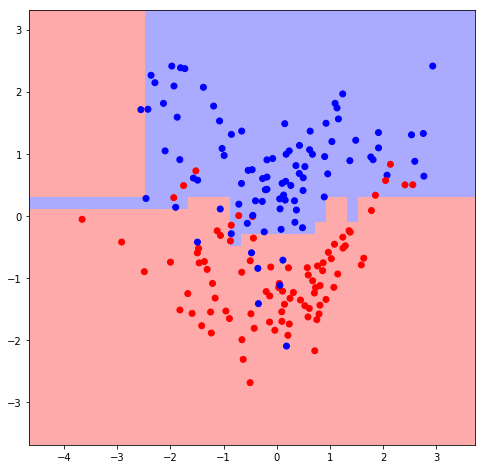

In [208]:
plot_surface(X_test, y_test, gbdt)

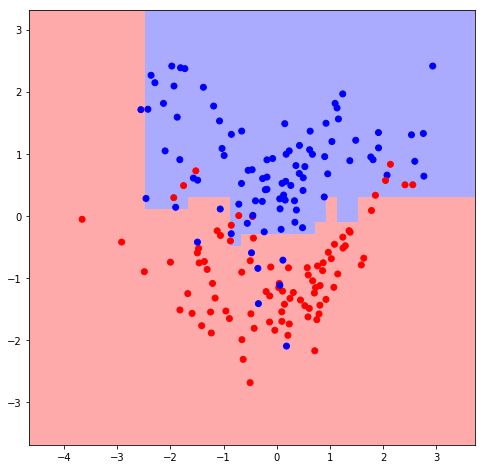

In [209]:
plot_surface(X_test, y_test, dt)

С помощью градиентного бустинга также можно находить выбросы в данных;

Выбросами будут те точки, градиент на которых максимален по модулю.

# Recap

1) Беггинг уменьшает разброс

2) Бустинг уменьшает смещение и разброс

3) Композиции тем менее эффективны, чем более коррелируют базовые алгоритмы
